
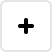
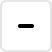
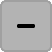
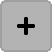
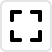
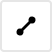
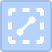

In [1]:
import numpy as np
import pandas as pd

from lets_plot import *
from lets_plot.mapping import as_discrete
LetsPlot.setup_html()

In [2]:
def dump_plot(plot):
    import json
    from lets_plot._type_utils import standardize_dict
    
    plot_dict = standardize_dict(plot.as_dict())
    plot_json = json.dumps(plot_dict, indent=2)
    print(plot_json)

In [3]:
SKIP_DEFAULT = True
DRAW_QUANTILES = [.25, .5, .75]

In [4]:
def plot_matrix(plots=[], width=400, height=300, columns=2):
    bunch = GGBunch()
    for i in range(len(plots)):
        row = int(i / columns)
        column = i % columns
        bunch.add_plot(plots[i], column * width, row * height, width, height)
    return bunch.show()

In [5]:
def skip_filter(target_list, skip=SKIP_DEFAULT):
    if not skip:
        return target_list
    return list(filter(lambda elem: not 'skip' in elem or not elem['skip'], target_list))

## Test datasets

In [6]:
mpg_df = pd.read_csv("https://raw.githubusercontent.com/JetBrains/lets-plot-docs/master/data/mpg.csv")

mpg_df.head()

Unnamed: 0 manufacturer model  displ  year  cyl       trans drv  cty  hwy  \
0           1         audi    a4    1.8  1999    4    auto(l5)   f   18   29   
1           2         audi    a4    1.8  1999    4  manual(m5)   f   21   29   
2           3         audi    a4    2.0  2008    4  manual(m6)   f   20   31   
3           4         audi    a4    2.0  2008    4    auto(av)   f   21   30   
4           5         audi    a4    2.8  1999    6    auto(l5)   f   16   26   

  fl    class  
0  p  compact  
1  p  compact  
2  p  compact  
3  p  compact  
4  p  compact

In [7]:
def construct_violin_df(df, xname, yname, n=512):
    from functools import reduce

    from scipy.stats import gaussian_kde

    def get_density(values):
        def nrd0_bw(kde):
            iqr = np.quantile(kde.dataset, .75) - np.quantile(kde.dataset, .25)
            std = np.std(kde.dataset)
            size = kde.dataset.size
            if iqr > 0:
                return .9 * min(std, iqr / 1.34) * (size ** -.2)
            if std > 0:
                return .9 * std * (size ** -.2)

        if values.min() == values.max():
            return {yname: np.array([values.min()]), 'density': np.array([1])}

        yrange = np.linspace(values.min(), values.max(), n)

        return {yname: yrange, 'density': gaussian_kde(values, bw_method=nrd0_bw)(yrange)}

    def reducer(agg_df, xval):
        density = get_density(df[df[xname] == xval][yname])
        y = density[yname]
        x = [xval] * y.size
        density = density['density']

        return pd.concat([agg_df, pd.DataFrame({xname: x, yname: y, 'density': density})], ignore_index=True)

    result = reduce(reducer, df[xname].unique(), pd.DataFrame(columns=[xname, yname, 'density']))
    max_density = result['density'].max()
    result['violinwidth'] = result['density'] / max_density
    return result

violin_df = construct_violin_df(mpg_df, 'drv', 'hwy')
violin_df.head()

drv        hwy   density  violinwidth
0   f  17.000000  0.005613     0.066527
1   f  17.052838  0.005752     0.068182
2   f  17.105675  0.005895     0.069876
3   f  17.158513  0.006041     0.071609
4   f  17.211350  0.006191     0.073381

## Minimalistic example

In [8]:
ggplot(mpg_df, aes(y='hwy')) + geom_violin() + ggtitle("Simplest example")

In [9]:
#mpg_df.cyl.value_counts()

In [10]:
#mpg_df[mpg_df['cyl'] == 4]

In [11]:
#p_v = ggplot(mpg_df, aes(x='cyl', y='hwy')) + geom_violin()
#p_b = ggplot(mpg_df, aes(x='cyl', y='hwy')) + geom_boxplot()
#plot_matrix([p_v, p_b], width=600, height=200, columns=1)

In [24]:
mpg_df[['cyl', 'hwy']]

cyl  hwy
0      4   29
1      4   29
2      4   31
3      4   30
4      6   26
..   ...  ...
229    4   28
230    4   29
231    6   26
232    6   26
233    6   26

[234 rows x 2 columns]

In [34]:
def corrupted_data():
    df = mpg_df.copy()
    df = df[df.cyl != 8]
    df = df[(df.hwy >= 28)&(df.hwy < 30)]

    return {
        'x': list(df.cyl),
        'y': list(df.hwy),
    }

p = ggplot(corrupted_data(), aes(x='x', y='y')) + geom_violin()

#dump_plot(p)
str(corrupted_data()['x']), str(corrupted_data()['y'])

('[4, 4, 4, 6, 4, 4, 6, 4, 4, 4, 6, 4, 6, 4, 4, 4, 4, 4, 4, 4, 5, 5, 4, 5, 5, 4, 4, 4, 4]',
 '[29, 29, 28, 29, 29, 29, 28, 29, 28, 29, 28, 29, 28, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 28, 29, 29, 29, 28, 29]')

In [72]:
import numpy as np

x = np.array([6, 4, 5]) - 3
y = np.array([28, 29, 29]) - 28

ggplot({'x': x, 'y': y}, aes('x', 'y')) + geom_violin()

In [84]:
x = [1, 3, 2]
y = [2, 0, 1]
ggplot({'x': x, 'y': y}, aes('x', 'y')) + geom_violin()

## Comparison of geoms

In [13]:
p_d = ggplot(mpg_df) + \
    geom_density(aes(x='hwy', fill='drv'), color='black', alpha=.5) + \
    facet_grid(x='drv') + \
    coord_flip() + \
    ggtitle("geom_density()")
p_v = ggplot(mpg_df, aes(x=as_discrete('drv', order=1), y='hwy')) + \
    geom_violin(aes(fill='drv'), alpha=.5) + \
    ggtitle("geom_violin()")

plot_matrix([p_d, p_v])

## Original parameters

### `draw_quantiles`

In [14]:
tests = [
    {'draw_quantiles': None}, # default
    {'draw_quantiles': [.05, .5, .95]}, # all correct
    {'draw_quantiles': (1/3, .5, 2/3)}, # strange, but correct
    {'draw_quantiles': [.25]}, # only one
    {'draw_quantiles': []}, # empty
    {'draw_quantiles': [0, .5, 1]}, # include borders
    {'draw_quantiles': [-1, .5, 2], 'skip': True}, # beyond borders
    {'draw_quantiles': ['0.25', '0.5', '0.75'], 'skip': True}, # invalid values
    {'draw_quantiles': [True, False], 'skip': True}, # totally invalid values
    {'draw_quantiles': 0.5, 'skip': True}, # wrong parameter type
    {'draw_quantiles': True, 'skip': True}, # another wrong parameter type
    {'draw_quantiles': '0.25', 'skip': True}, # even worse parameter type
    {'draw_quantiles': object(), 'skip': True}, # totally wrong parameter type
]

plot_matrix([
    ggplot(mpg_df, aes('drv', 'hwy')) + \
        geom_violin(draw_quantiles=test['draw_quantiles']) + \
        ggtitle("draw_quantiles={0}".format(test['draw_quantiles']))
    for test in skip_filter(tests)
])

### `scale`

In [15]:
tests = [
    {'scale': None}, # default
    {'scale': 'area'}, # correct scale
    {'scale': 'count'}, # correct scale
    {'scale': 'width'}, # correct scale
    {'scale': 'unsupported', 'skip': True}, # incorrect scale
    {'scale': False, 'skip': True}, # very incorrect scale
    {'scale': object(), 'skip': True}, # totally incorrect scale
]

plot_matrix([
    ggplot(mpg_df, aes('drv', 'hwy')) + \
        geom_violin(scale=test['scale'], \
                    draw_quantiles=DRAW_QUANTILES) + \
        ggtitle("scale={0}".format(test['scale']))
    for test in skip_filter(tests)
])

## Custom density parameters

In [16]:
p = ggplot(mpg_df, aes('drv', 'hwy'))
p_default = p + geom_violin(draw_quantiles=DRAW_QUANTILES) + ggtitle("Default")
p_kernel = p + geom_violin(draw_quantiles=DRAW_QUANTILES, kernel='epanechikov') + ggtitle("kernel='epanechikov'")
p_bw = p + geom_violin(draw_quantiles=DRAW_QUANTILES, bw=.1) + ggtitle("bw=0.1")
p_adjust = p + geom_violin(draw_quantiles=DRAW_QUANTILES, adjust=2) + ggtitle("adjust=2")

plot_matrix([p_default, p_kernel, p_bw, p_adjust])

## Grouping and tooltips

In [17]:
ggplot(mpg_df, aes(x='drv', y='hwy')) + \
    geom_violin(aes(group='year', fill=as_discrete('year')), \
                draw_quantiles=DRAW_QUANTILES, \
                tooltips=layer_tooltips().line('^x')
        .line('year|@year')
        .line('hwy|@hwy')
        .line('violinwidth|@..violinwidth..')
        .line('density|@..density..')
        .line('count|@..count..')
        .line('scaled|@..scaled..')) + \
    ggtitle("Grouping and tooltips")

## Facets

In [18]:
ggplot(mpg_df, aes(x='drv', y='hwy')) + \
    geom_violin(aes(fill=as_discrete('year')), draw_quantiles=DRAW_QUANTILES) + \
    facet_grid(y='year')

## `coord_flip()`

In [19]:
ggplot(mpg_df, aes('drv', 'hwy')) + \
    geom_violin(draw_quantiles=DRAW_QUANTILES) + \
    coord_flip() + \
    ggtitle("Use coord_flip()")

## "identity" statistic

In [20]:
ggplot(violin_df, aes('drv', 'hwy')) + \
    geom_violin(aes(violinwidth='violinwidth'), stat='identity', \
                draw_quantiles=DRAW_QUANTILES) + \
    ggtitle("Use 'identity' statistic")

## Additional layers

In [21]:
ggplot(mpg_df, aes(as_discrete('drv', order=-1), 'hwy')) + \
    geom_violin(aes(color='drv', fill='drv'), alpha=.5, size=2, \
                draw_quantiles=DRAW_QUANTILES,
                sampling=sampling_group_systematic(2)) + \
    scale_y_continuous(breaks=list(range(12, 29, 2))) + \
    scale_color_brewer(type='qual', palette='Set1') + \
    scale_fill_brewer(type='qual', palette='Set1') + \
    ylim(12, 28) + \
    coord_fixed(ratio=.2) + \
    theme_grey() + \
    ggtitle("Some additional aesthetics, parameters and layers")

In [22]:
ggplot(mpg_df, aes(x='drv', y='hwy')) + \
    geom_violin() + \
    geom_boxplot(width=.1)

## Dataset with NaN's

In [23]:
def get_plot(dataset):
    aesthetics = aes('x', 'y', violinwidth='vw') if dataset['stat'] == 'identity' else aes('x', 'y')
    return ggplot(dataset['df'], aesthetics) + \
        geom_violin(stat=dataset['stat']) + \
        ggtitle(dataset['title'])

datasets = [
    {
        'title': "Empty df",
        'df': pd.DataFrame({
            'x': [],
            'y': []
        }),
        'stat': 'ydensity',
    },
    {
        'title': "NaN's for all x and y",
        'df': pd.DataFrame({
            'x': [np.nan, np.nan, np.nan, np.nan],
            'y': [np.nan, np.nan, np.nan, np.nan],
        }),
        'stat': 'ydensity',
    },
    {
        'title': "NaN's for all x",
        'df': pd.DataFrame({
            'x': [np.nan, np.nan, np.nan, np.nan],
            'y': [0, 1, 0, 1],
        }),
        'stat': 'ydensity',
    },
    {
        'title': "NaN's for all y",
        'df': pd.DataFrame({
            'x': ["A", "A", "B", "B"],
            'y': [np.nan, np.nan, np.nan, np.nan],
        }),
        'stat': 'ydensity',
    },
    {
        'title': "x in [A, NaN]",
        'df': pd.DataFrame({
            'x': ["A", "A", np.nan, np.nan],
            'y': [0, 1, 0, 1],
        }),
        'stat': 'ydensity',
    },
    {
        'title': "y := NaN for all x == B",
        'df': pd.DataFrame({
            'x': ["A", "A", "B", "B"],
            'y': [0, 1, np.nan, np.nan],
        }),
        'stat': 'ydensity',
    },
    {
        'title': "|y| = 1 for x == B",
        'df': pd.DataFrame({
            'x': ["A", "A", "B"],
            'y': [0, 1, 0],
        }),
        'stat': 'ydensity',
    },
    {
        'title': "Empty df",
        'df': pd.DataFrame({
            'x': [],
            'y': [],
            'vw': [],
        }),
        'stat': 'identity',
    },
    {
        'title': "NaN's for all x and y and vw",
        'df': pd.DataFrame({
            'x': [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
            'y': [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
            'vw': [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
        }),
        'stat': 'identity',
    },
    {
        'title': "NaN's for all x",
        'df': pd.DataFrame({
            'x': [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
            'y': [0, 1, 2, 0, 1, 2],
            'vw': [.2, .6, .2, .1, .8, .1],
        }),
        'stat': 'identity',
    },
    {
        'title': "NaN's for all y",
        'df': pd.DataFrame({
            'x': ["A", "A", "A", "B", "B", "B"],
            'y': [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
            'vw': [.2, .6, .2, .1, .8, .1],
        }),
        'stat': 'identity',
    },
    {
        'title': "NaN's for all vw",
        'df': pd.DataFrame({
            'x': ["A", "A", "A", "B", "B", "B"],
            'y': [0, 1, 2, 0, 1, 2],
            'vw': [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
        }),
        'stat': 'identity',
    },
    {
        'title': "x in [A, NaN]",
        'df': pd.DataFrame({
            'x': ["A", "A", "A", np.nan, np.nan, np.nan],
            'y': [0, 1, 2, 0, 1, 2],
            'vw': [.2, .6, .2, .1, .8, .1],
        }),
        'stat': 'identity',
    },
    {
        'title': "y := NaN for all x == B",
        'df': pd.DataFrame({
            'x': ["A", "A", "A", "B", "B", "B"],
            'y': [0, 1, 2, np.nan, np.nan, np.nan],
            'vw': [.2, .6, .2, .1, .8, .1],
        }),
        'stat': 'identity',
    },
    {
        'title': "vw := NaN for all x == B",
        'df': pd.DataFrame({
            'x': ["A", "A", "A", "B", "B", "B"],
            'y': [0, 1, 2, 0, 1, 2],
            'vw': [.2, .6, .2, np.nan, np.nan, np.nan],
        }),
        'stat': 'identity',
    },
    {
        'title': "Some of y is NaN",
        'df': pd.DataFrame({
            'x': ["A", "A", "A", "B", "B", "B"],
            'y': [0, 1, 2, 0, np.nan, 2],
            'vw': [.2, .6, .2, .1, .8, .1],
        }),
        'stat': 'identity',
    },
    {
        'title': "Some of vw is NaN",
        'df': pd.DataFrame({
            'x': ["A", "A", "A", "B", "B", "B"],
            'y': [0, 1, 2, 0, 1, 2],
            'vw': [.2, .6, .2, .1, np.nan, .1],
        }),
        'stat': 'identity',
    },
    {
        'title': "|y| = |vw| = 1 for x == B",
        'df': pd.DataFrame({
            'x': ["A", "A", "A", "B"],
            'y': [0, 1, 2, 0],
            'vw': [.2, .6, .2, 1.0],
        }),
        'stat': 'identity',
    },
]

plot_matrix([get_plot(dataset) for dataset in skip_filter(datasets)])